# Profiling Surface

In [2]:
import math
import os
import pandas as pd
import numpy as np
import sklearn.tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

from googletrans import Translator
import copy
import subprocess

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import dexplot as dx
from xgboost import XGBClassifier
import lightgbm as lgb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
os.chdir('C:\\Users\\paperspace\\Desktop\\Microsoft\\Surface')

In [63]:
tag_df = pd.read_csv('Surface.csv')

C:\Users\paperspace\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,59,61,71,72,75,76,77,78,80,81,82,83,85,102,103,134,156,180,182,184,185,186,187,192,193,194,197,199,201,206,211,212,213,214,215,218,220,221,233,234,235,236,237,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Conducting Analysis on Surface Data
- I am going to begin by separating out the surface dataset by consumer, commercial_edu, and commercial non edu
- I will then create models to determine which features are the most important
- Finally, I will be plotting continuous and categorical features depending on whether they were identified as important features by the model

In [260]:
def profile_surface(df, target_encoding = 'mean'):

    #read in data file
    df = pd.read_csv('Surface.csv')

    #create commercial and consumer datasets
    consumer = df[df['Feedback_UserType'] == 'Consumer']
    commercial = df[df['Feedback_UserType'] == 'Commercial']
    commercial_edu = commercial[commercial['User_Commercial_HasEducation'] == 1]
    commercial_nonedu = commercial[commercial['User_Commercial_HasEducation'] == 0]

    #remove columns from data that are missing all or almost all of their data
    def remove_completely_missing_columns(df):
    
        '''this function removes all columns that are missing more than 90% all values'''
    
    
        #create missingness df
        missingness = pd.DataFrame(df.isna().sum()).reset_index().rename(columns = {'index':'column', 0:'num_missing'})

        print(f'shape before deleting missing columns: {df.shape}')
        #find columns that are missing all of their data and drop them
        all_missing = []
        for idx, row in missingness.iterrows():
            #filter out columns missing most of their values
            if row[1] > (.5 * df.shape[0]):
                all_missing.append(row[0])

        #drop these columns
        df = df.drop([x for x in all_missing], axis = 1)

        print(f'shape after deleting missing columns: {df.shape}')
    
        return df
    print('-------->-------->Removing Missing Features-------->-------->')
    print(' ')
    print(' ')
    #cut out missing columns from consumers
    consumer = remove_completely_missing_columns(consumer)
    
    #cut out missing columns from commercial edu
    commercial_edu = remove_completely_missing_columns(commercial_edu)
    
    #cut out missing columns from commercial nonedu
    commercial_nonedu = remove_completely_missing_columns(commercial_nonedu)
    
    #so there are several features that are numeric, but only contain a small number of unique values, we want to treat these as categorical so we can plot them easier
    #this function forces these features that have 20 or less unique values to objects
    def force_to_cat(df):
    
        '''
        this function forces all columns in these dfs to be objects if their number of unique values is low
    
        '''
    
        non_cat = df.select_dtypes(exclude = ['object'])
        for col in non_cat:
            #we have to specify that feedback rating value is not going to be converted
            if (df[col].nunique() <= 20) & (col != 'Feedback_RatingValue'):
                df[col] = df[col].astype(str)
            
        return df
    
    #force to categories in consumer, commercial edu, and commercial nonedu
    consumer = force_to_cat(consumer)
    commercial_edu = force_to_cat(commercial_edu)
    commercial_nonedu = force_to_cat(commercial_nonedu)
    
        
    #target encoding, since we have so many features with high cardinality, we want to encode these levels of cat features with the mean/median/mode of the target (NPS)    
    def target_encoder(df, column, target, index=None, method='mean'):

        """

        Target-based encoding is numerization of a categorical variables via the target variable. Main purpose is to deal

        with high cardinality categorical features without exploding dimensionality. This replaces the categorical variable

        with just one new numerical variable. Each category or level of the categorical variable is represented by a

        summary statistic of the target for that level.



        Args:

            df (pandas df): Pandas DataFrame containing the categorical column and target.

            column (str): Categorical variable column to be encoded.

            target (str): Target on which to encode.

            index (arr): Can be supplied to use targets only from the train index. Avoids data leakage from the test fold

            method (str): Summary statistic of the target. Mean, median or std. deviation.



        Returns:

            arr: Encoded categorical column.



        """



        index = df.index if index is None else index # Encode the entire input df if no specific indices is supplied



        if method == 'mean':

            encoded_column = df[column].map(df.loc[index].groupby(column)[target].mean())

        elif method == 'median':

            encoded_column = df[column].map(df.loc[index].groupby(column)[target].median())

        elif method == 'std':

            encoded_column = df[column].map(df.loc[index].groupby(column)[target].std())
    
    #need to update this to allow for mote imputation
    #     elif method == 'mode':
        
    #         encoded_column = df[column].map(df.loc[index].groupby(column)[target].apply(lambda x: x.mode()))

        else:

            raise ValueError("Incorrect method supplied: '{}'. Must be one of 'mean', 'median', 'std'".format(method))



        return encoded_column
    print(' ')
    print('---------->--------->Target Encoding Categorical Features-------->--------->')
    print(' ')
    print(' ')
    #encode categorical features now
    #encode features with mean of target
    dfs = [consumer, commercial_edu, commercial_nonedu]

    for df in dfs:
        for col in df.drop(['Feedback_ID'], axis = 1).select_dtypes(include = ['object']).columns:
            df[col] = target_encoder(df, column = col, target = 'Feedback_RatingValue', method = target_encoding)
            
    print(' ')
    print(' ')
    print('-------->-------->Dividing Data Into Feature and Label Sets-------->-------->')
    #now we are going to create feature and label sets for consumer, commercial edu, and commercial nonedu
    #create feature and label sets for consumer
    consumer_features = consumer.drop(['Feedback_ID', 'Feedback_Rating', 'Feedback_RatingValue', 'Feedback_OcvId1', 'NPS'], axis = 1).fillna(-999)
    
    #map class labels onto target
    consumer_labels = consumer['Feedback_RatingValue'].map({-100:0, 0:1, 100:2})

    #create feature and label sets for commercial_edu
    commercial_edu_features = commercial_edu.drop(['Feedback_ID', 'Feedback_Rating', 'Feedback_RatingValue', 'Feedback_OcvId1', 'NPS'], axis = 1).fillna(-999)
    
    #map class labels onto target
    commercial_edu_labels = commercial_edu['Feedback_RatingValue'].map({-100:0, 0:1, 100:2})

    #create feature and label sets for commercial_non-edu
    commercial_nonedu_features = commercial_nonedu.drop(['Feedback_ID', 'Feedback_Rating', 'Feedback_RatingValue', 'Feedback_OcvId1', 'NPS'], axis = 1).fillna(-999)
    
    #map class labels onto target
    commercial_nonedu_labels = commercial_nonedu['Feedback_RatingValue'].map({-100:0, 0:1, 100:2})
    
    print(' ')
    print('-------->-------->Determining Drivers for Consumer, Commercial Edu, and Commercial Non-Edu-------->-------->')
    print(' ')
    print(' ')
    #create train/test split to feed into Random Forest, we are using this algorithm to filter out important experiments for NPS
    X_train, X_test, y_train, y_test = train_test_split(consumer_features, consumer_labels, test_size=0.2)
    
    print('Beginning Consumer Analysis')
    print(' ')
    print(' ')
    # run gridsearch for best Random Forest params, in this case I am using RandomizedSearchCV rather than GridsearchCV, which has been shown to have similar
    # performance to Gridsearch, but takes significantly less time 
    rf = RandomForestClassifier(random_state=0, n_estimators = 100)
    param_grid = {'n_estimators': [50, 100, 250, 500, 750, 1000, 1250, 1500],#'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth': [2,5,10,25,None]}

    CV_rf = RandomizedSearchCV(estimator=rf, n_jobs=-1, param_distributions=param_grid, verbose=10, scoring='neg_log_loss',cv= 5)
    CV_rf.fit(X_train, y_train)
    
    n_estimators, max_depth = CV_rf.best_params_.values()



    rf = RandomForestClassifier(random_state = 0, n_estimators = n_estimators, max_depth = max_depth)
    rf.fit(X_train,y_train)
    print(' ')
    # print('Scoring on Test Data')
    # print(rf.score(X_test,y_test))
    
    #getting feature importances greatest to least
    learners = rf.feature_importances_.argsort()[::-1]
    
    features = pd.DataFrame(X_train.columns[learners], rf.feature_importances_[learners])
    
    #only using features that had more than .015 splits
    features = features[features.index>0.015]

    comsumer_feature_importances_df = pd.DataFrame({'Rank': list(range(len(learners))), 'Features': X_train.iloc[:, [x for x in learners]].columns})


    print(' ')
    print('Beginning Commercial-Edu Analysis')
    print(' ')
    X_train, X_test, y_train, y_test = train_test_split(commercial_edu_features, commercial_edu_labels, test_size=0.2)
    

    # run gridsearch for best Random Forest params, in this case I am using RandomizedSearchCV rather than GridsearchCV, which has been shown to have similar
    # performance to Gridsearch, but takes significantly less time 
    rf = RandomForestClassifier(random_state=0, n_estimators = 100)
    param_grid = {'n_estimators': [50, 100, 250, 500, 750, 1000, 1250, 1500],#'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth': [2,5,10,25,None]}

    CV_rf = RandomizedSearchCV(estimator=rf, n_jobs=-1, param_distributions=param_grid, verbose=10, scoring='neg_log_loss',cv= 5)
    CV_rf.fit(X_train, y_train)
    
    n_estimators, max_depth = CV_rf.best_params_.values()



    rf = RandomForestClassifier(random_state = 0, n_estimators = n_estimators, max_depth = max_depth)
    rf.fit(X_train,y_train)
    print(' ')
    # print('Scoring on Test Data')
    # print(rf.score(X_test,y_test))
    
    #getting feature importances greatest to least
    learners = rf.feature_importances_.argsort()[::-1]
    
    features = pd.DataFrame(X_train.columns[learners], rf.feature_importances_[learners])
    
    #only using features that had more than .015 splits
    features = features[features.index>0.015]

    commercial_edu_feature_importances_df = pd.DataFrame({'Rank': list(range(len(learners))), 'Features': X_train.iloc[:, [x for x in learners]].columns})

    print(' ')
    print('Beginning Commercial Non-Edu Analysis')
    print(' ')

    X_train, X_test, y_train, y_test = train_test_split(commercial_nonedu_features, commercial_nonedu_labels, test_size=0.2)
    
    # run gridsearch for best Random Forest params, in this case I am using RandomizedSearchCV rather than GridsearchCV, which has been shown to have similar
    # performance to Gridsearch, but takes significantly less time 
    rf = RandomForestClassifier(random_state=0, n_estimators = 100)
    param_grid = {'n_estimators': [50, 100, 250, 500, 750, 1000, 1250, 1500],#'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth': [2,5,10,25,None]}

    CV_rf = RandomizedSearchCV(estimator=rf, n_jobs=-1, param_distributions=param_grid, verbose=10, scoring='neg_log_loss',cv= 5)
    CV_rf.fit(X_train, y_train)
    
    n_estimators, max_depth = CV_rf.best_params_.values()

    rf = RandomForestClassifier(random_state = 0, n_estimators = n_estimators, max_depth = max_depth)
    rf.fit(X_train,y_train)
    print(' ')
    # print('Scoring on Test Data')
    # print(rf.score(X_test,y_test))
    
    #getting feature importances greatest to least
    learners = rf.feature_importances_.argsort()[::-1]
    
    features = pd.DataFrame(X_train.columns[learners], rf.feature_importances_[learners])
    
    #only using features that had more than .015 splits
    features = features[features.index>0.015]

    commercial_nonedu_feature_importances_df = pd.DataFrame({'Rank': list(range(len(learners))), 'Features': X_train.iloc[:, [x for x in learners]].columns})

    print('********Driver Analysis Complete********')
    
    #create list of top 50 features in top 50 of feature importances for consumer
    consumer_important = []
    for idx, row in comsumer_feature_importances_df.head(50).iterrows():
        consumer_important.append(row[1])
        
    #creat list of top 50 important features for commercial edu
    commercial_edu_important = []
    for idx, row in commercial_edu_feature_importances_df.head(50).iterrows():
        commercial_edu_important.append(row[1])
        
    #create list of top 50 important features for commercial nonedu
    commercial_nonedu_important = []
    for idx, row in commercial_nonedu_feature_importances_df.head(50).iterrows():
        commercial_nonedu_important.append(row[1])
    
    #reimporting data since we target encoded earlier (could probably just rename feature sets and encode those too)
    df = pd.read_csv('Surface.csv')

    #create commercial and consumer datasets
    consumer = df[df['Feedback_UserType'] == 'Consumer']
    commercial = df[df['Feedback_UserType'] == 'Commercial']
    commercial_edu = commercial[commercial['User_Commercial_HasEducation'] == 1]
    commercial_nonedu = commercial[commercial['User_Commercial_HasEducation'] == 0]

    ### Remove Completely Missing Columns in Datasets

    consumer = remove_completely_missing_columns(consumer)

    commercial_edu = remove_completely_missing_columns(commercial_edu)

    commercial_nonedu = remove_completely_missing_columns(commercial_nonedu)
    
    #force to cat as before
    consumer = force_to_cat(consumer)
    commercial_edu = force_to_cat(commercial_edu)
    commercial_nonedu = force_to_cat(commercial_nonedu)
    
    #filter dfs for 50 most important features in each
    consumer_important_df = consumer.loc[:, [col for col in consumer_important]]
    commercial_edu_important_df = commercial_edu.loc[:, [col for col in commercial_edu_important]]
    commercial_nonedu_important_df = commercial_nonedu.loc[:, [col for col in commercial_nonedu_important]]
    
    #tag each df so that I can concatenate them into 1 for nps plots
    consumer_important_df['df_tag'] = 'Consumer'
    commercial_edu_important_df['df_tag'] = 'Commercial Edu'
    commercial_nonedu_important_df['df_tag'] = 'Commercial Non-Edu'
    
    #create combined df
    combined = pd.concat([consumer_important_df, commercial_edu_important_df, commercial_nonedu_important_df], axis = 0)
    
    #if a string in our df is a date, convert it to datetime
    dfs = [consumer_important_df, commercial_edu_important_df, commercial_nonedu_important_df]
    
    #create a function to determine if a feature can be interpreted as a date
    from dateutil.parser import parse

    def is_date(string, fuzzy=False):
        """
        Return whether the string can be interpreted as a date.

        :param string: str, string to check for date
        :param fuzzy: bool, ignore unknown tokens in string if True
        """
        try: 
            parse(string, fuzzy=fuzzy)
            return True

        except ValueError:
            return False
    
    print('---->---->Parsing DateTime Features---->---->')
    print(' ')
    #create list of strings for columns that can be parsed into dates
    dates = [is_date(x) for x in df.select_dtypes(include = 'object').iloc[0, :] if str(x) != 'nan']
    colnames = [x for x in df.select_dtypes(include = 'object').columns]

    date_cols = []
    for idx, row in pd.DataFrame(zip(colnames, dates)).iterrows():
        if row[1] == True:
            date_cols.append(row[0])
    
    #filter the date_cols list for only columns that contain the word "date", this is becuase the loop is returning a couple of columns that are numbers that could be dates but arent
    
    #make list of columns into a df so we can use str.contains
    date_cols = pd.DataFrame(date_cols).rename(columns = {0:'date_cols'})
    
    date_cols = date_cols[date_cols['date_cols'].str.contains('Date') == True]
    
    date_cols = [x for x in date_cols['date_cols']]
            
    combined[date_cols] = pd.to_datetime(combined[date_cols].stack()).unstack()
    
    #create separate data for consumer, commercial edu, and commercial nonedu
    consumer = combined[combined['df_tag'] == 'Consumer'].dropna(axis = 1, how = 'all')
    comedu = combined[combined['df_tag'] == 'Commercial Edu'].dropna(axis = 1, how = 'all')
    nonedu = combined[combined['df_tag'] == 'Commercial Non-Edu'].dropna(axis = 1, how = 'all')
    
    

            
    print('*****************Data Ready for Plotting****************')
    
    
    def plot_cats(df, df2):
        
        df['Feedback_RatingValue'] = [x for x in df2['Feedback_RatingValue']]
    
        cats = df.select_dtypes(include = 'object')
        
        cats = pd.concat([cats, df['Feedback_RatingValue']], axis = 1)
    
    
        for feature in cats:
        
            if cats[feature].nunique() <= 10:
    
                counts = (cats.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
        
                plt.figure(figsize = (12, 7))
        
                sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage']\
                                                                                                    .sort_values().index][feature])
            
                plt.title(f'{feature} by NPS Rating')
                
                plt.show()
            
            elif (cats[feature].nunique() > 10) & (cats[feature].nunique() <= 20):
                
                counts = (cats.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
        
                plt.figure(figsize = (15, 7))
        
                sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage']\
                                                                                                                       .sort_values().index][feature])
                plt.title(f'{feature} by NPS Rating')
            
                plt.xticks(rotation = 60)
                
                plt.show()
            
            elif (cats[feature].nunique() > 20) & (cats[feature].nunique() <= 40):
            
                counts = (cats.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
        
                plt.figure(figsize = (18, 7))
        
                sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage']\
                                                                                                                       .sort_values().index][feature])
            
                plt.title(f'{feature} by NPS Rating')
            
                plt.xticks(rotation = 90)
                
                plt.show()
            
            elif cats[feature].nunique() > 40:
            
                top_30 = [x for x in pd.DataFrame(cats[feature].value_counts().nlargest(30)).reset_index().rename(columns = {'index':'values'})['values']]
            
                counts = (cats[cats[feature].isin(top_30)].groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
            
                plt.figure(figsize = (18, 7))
        
                sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage']\
                                                                                                                       .sort_values().index][feature])
            
                plt.title(f'{feature} by NPS Rating')
            
                plt.xticks(rotation = 90)
                
                plt.show()
                
        def plot_nums(df, bins):
    
            nums = df.select_dtypes(exclude = 'object')
    
            for feature in nums.columns:
        
                if feature == 'Feedback_RatingValue':
            
                    pass
            
                elif nums[feature].nunique() <= 40:
                    
                    counts = nums.groupby(['Feedback_RatingValue'])[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
                    
                    plt.figure(figsize = (12, 7))
                    
                    ax = sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = \
                                    counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage'].sort_values().index[feature]])
                    
                    plt.show()
        
                elif nums[feature].nunique() > 40:
            
                    nums[feature] = pd.qcut(nums[feature], bins, duplicates = 'drop')
        
                    counts = nums.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
        
                    plt.figure(figsize = (12, 7))

                    ax = sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage'].sort_values().index][feature])
        
                    plt.show()
                
    print(' ')
    print('-------->-------->Plotting Categorical Features for Consumer-------->-------->')
    print(' ')
                
    plot_cats(consumer, df)
    
    print(' ')
    print('-------->-------->Plotting Continuous Features for Consumer-------->-------->')
    print(' ')
    
    plot_nums(consumer, 10)

In [261]:
profile_surface(df)

-------->-------->Removing Missing Features-------->-------->
 
 
shape before deleting missing columns: (7362, 321)
shape after deleting missing columns: (7362, 70)
shape before deleting missing columns: (4138, 321)
shape after deleting missing columns: (4138, 244)
shape before deleting missing columns: (5640, 321)
shape after deleting missing columns: (5640, 237)
 
---------->--------->Target Encoding Categorical Features-------->--------->
 
 
 
 
-------->-------->Dividing Data Into Feature and Label Sets-------->-------->
 
-------->-------->Determining Drivers for Consumer, Commercial Edu, and Commercial Non-Edu-------->-------->
 
 
Beginning Consumer Analysis
 
 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   15.0s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   16.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.6s finished


 
 
Beginning Commercial-Edu Analysis
 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   19.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   22.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.5s finished


 
 
Beginning Commercial Non-Edu Analysis
 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   32.1s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   37.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.9s finished


 
********Driver Analysis Complete********


C:\Users\paperspace\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (17,59,61,71,72,75,76,77,78,80,81,82,83,85,102,103,134,156,180,182,184,185,186,187,192,193,194,197,199,201,206,211,212,213,214,215,218,220,221,233,234,235,236,237,241) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


shape before deleting missing columns: (7362, 321)
shape after deleting missing columns: (7362, 70)
shape before deleting missing columns: (4138, 321)
shape after deleting missing columns: (4138, 244)
shape before deleting missing columns: (5640, 321)
shape after deleting missing columns: (5640, 237)


C:\Users\paperspace\Anaconda3\lib\site-packages\ipykernel_launcher.py:329: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



---->---->Parsing DateTime Features---->---->
 
*****************Data Ready for Plotting****************
 
-------->-------->Plotting Categorical Features for Consumer-------->-------->
 


ValueError: Length of values does not match length of index

In [213]:
def plot_cats(df):
    
    cats = df.select_dtypes(include = 'object')
    
    cats['Feedback_RatingValue'] = [x for x in df['Feedback_RatingValue']]
    
    for feature in cats:
        
        if cats[feature].nunique() <= 10:
    
            counts = (cats.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
        
            plt.figure(figsize = (12, 7))
        
            sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage']\
                                                                                                    .sort_values().index][feature])
            
            plt.title(f'{feature} by NPS Rating')
                
            plt.show()
            
        elif (cats[feature].nunique() > 10) & (cats[feature].nunique() <= 20):
                
            counts = (cats.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
        
            plt.figure(figsize = (15, 7))
        
            sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage']\
                                                                                                                       .sort_values().index][feature])
            plt.title(f'{feature} by NPS Rating')
            
            plt.xticks(rotation = 60)
                
            plt.show()
            
        elif (cats[feature].nunique() > 20) & (cats[feature].nunique() <= 40):
            
            counts = (cats.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
        
            plt.figure(figsize = (18, 7))
        
            sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage']\
                                                                                                                       .sort_values().index][feature])
            
            plt.title(f'{feature} by NPS Rating')
            
            plt.xticks(rotation = 90)
                
            plt.show()
            
        elif cats[feature].nunique() > 40:
            
            top_30 = [x for x in pd.DataFrame(cats[feature].value_counts().nlargest(30)).reset_index().rename(columns = {'index':'values'})['values']]
            
            counts = (cats[cats[feature].isin(top_30)].groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
            
            plt.figure(figsize = (18, 7))
        
            sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage']\
                                                                                                                       .sort_values().index][feature])
            
            plt.title(f'{feature} by NPS Rating')
            
            plt.xticks(rotation = 90)
                
            plt.show()

In [228]:
def plot_nums(df, bins):
    
    nums = df.select_dtypes(exclude = 'object')
    
    for feature in nums.columns:
        
        if feature == 'Feedback_RatingValue':
            
            pass
        
        else:
            
            nums[feature] = pd.qcut(nums[feature], bins, duplicates = 'drop')
        
            counts = nums.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
        
            print(counts.shape)
        
            plt.figure(figsize = (12, 7))

            ax = sns.barplot(x = feature, y = 'percentage', hue = 'Feedback_RatingValue', data = counts, order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage'].sort_values().index][feature])
        
            plt.show()

C:\Users\paperspace\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


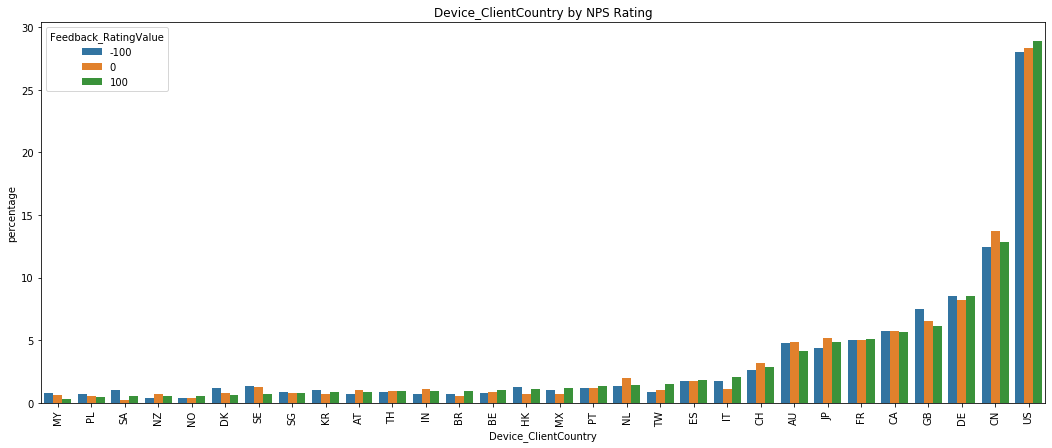

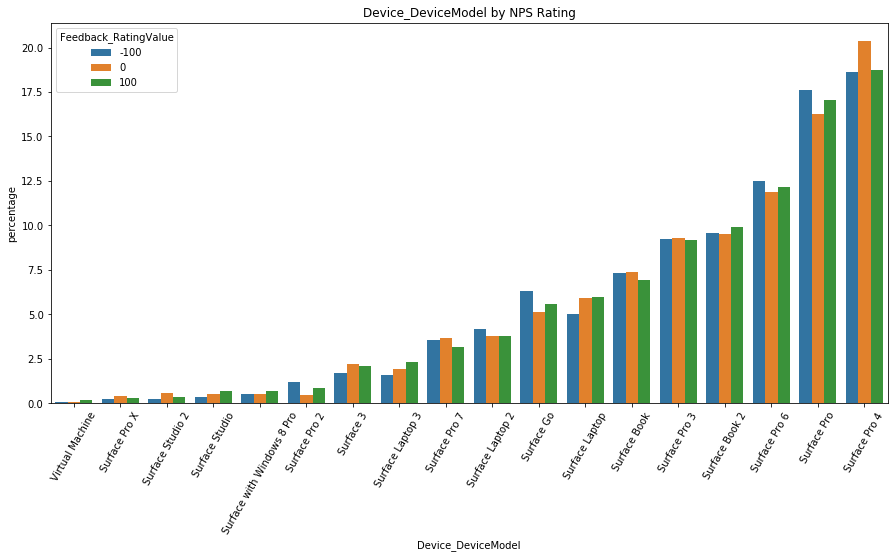

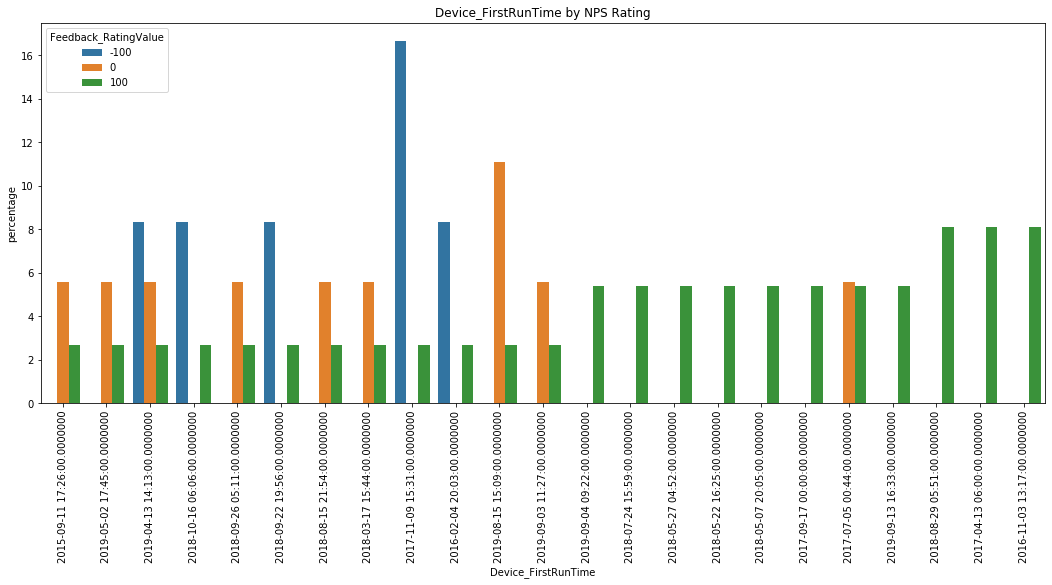

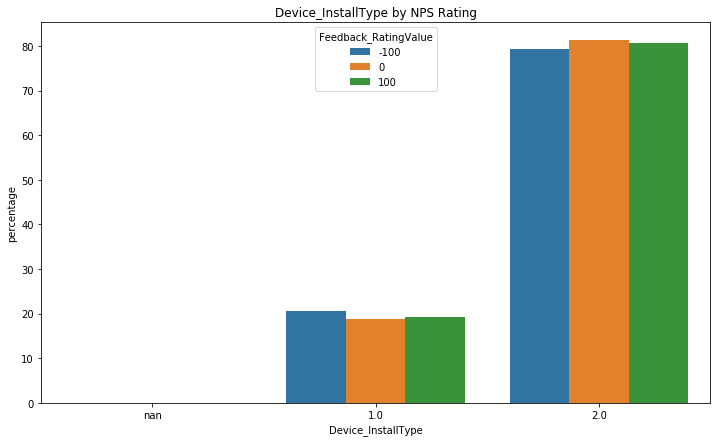

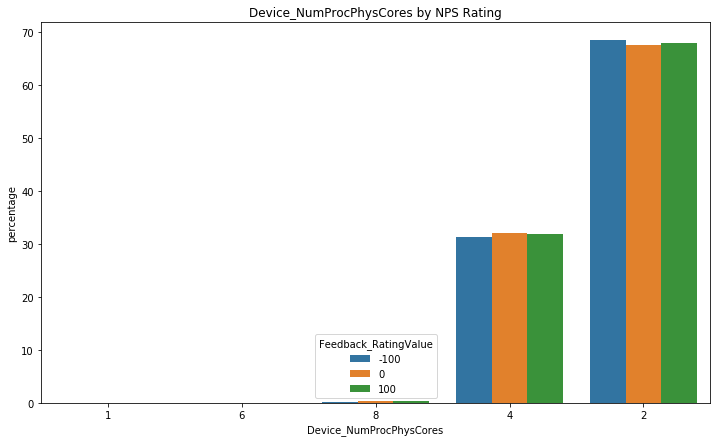

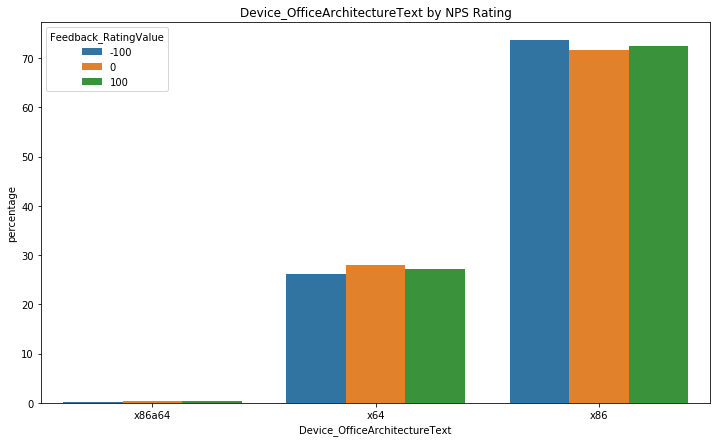

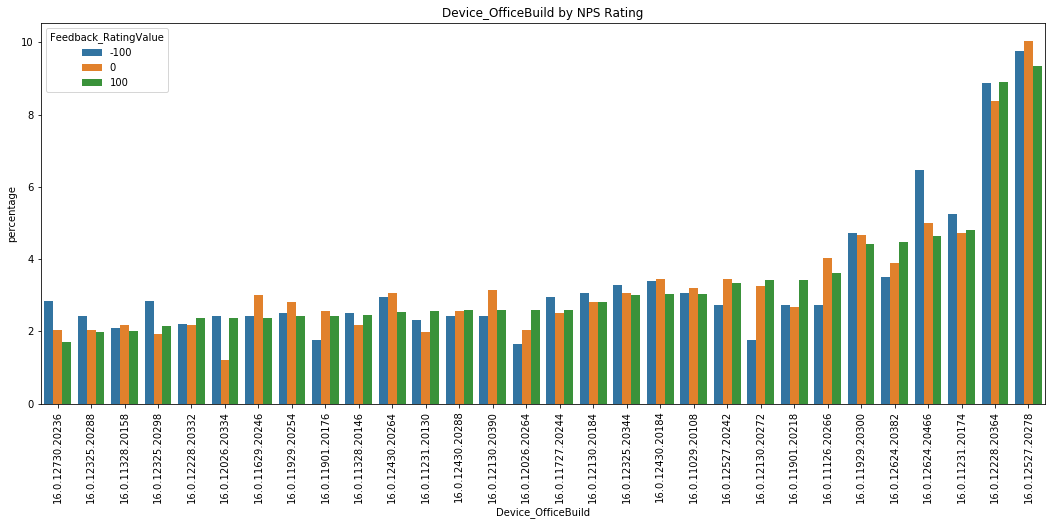

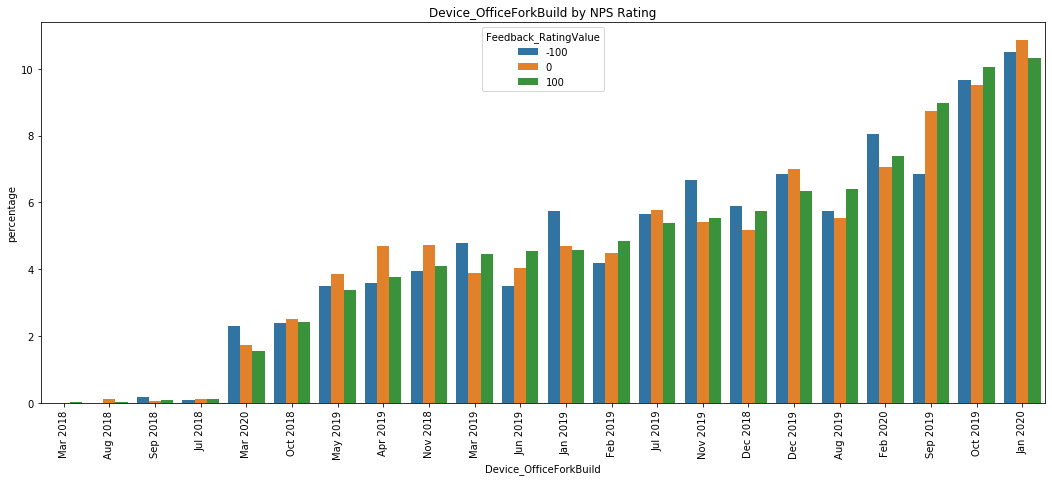

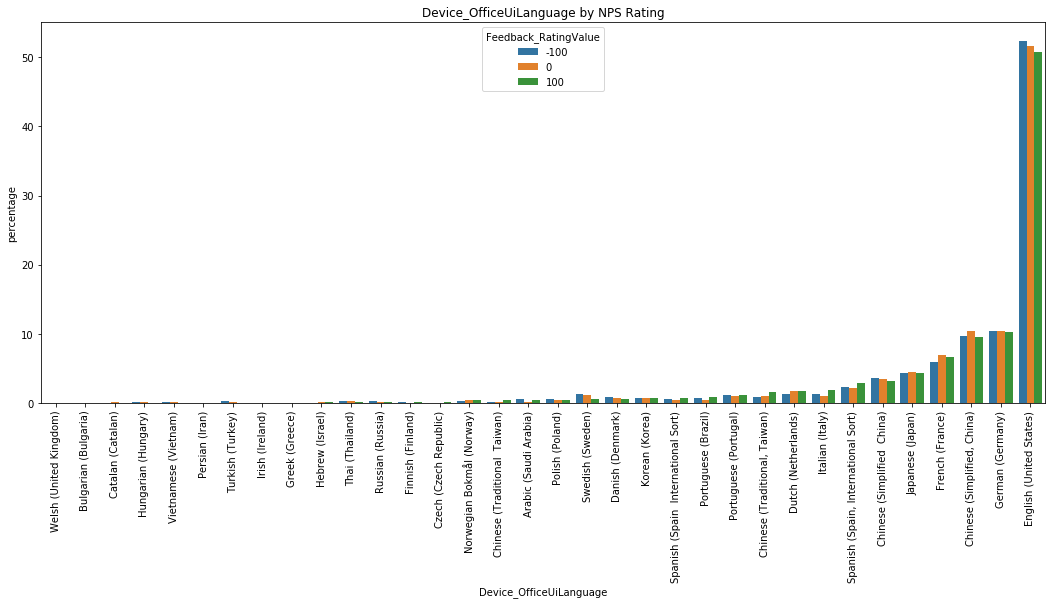

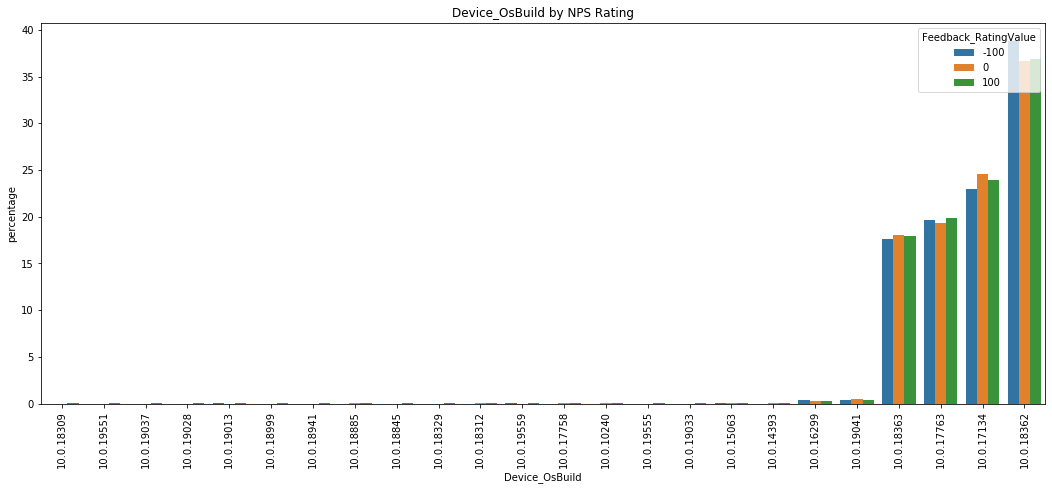

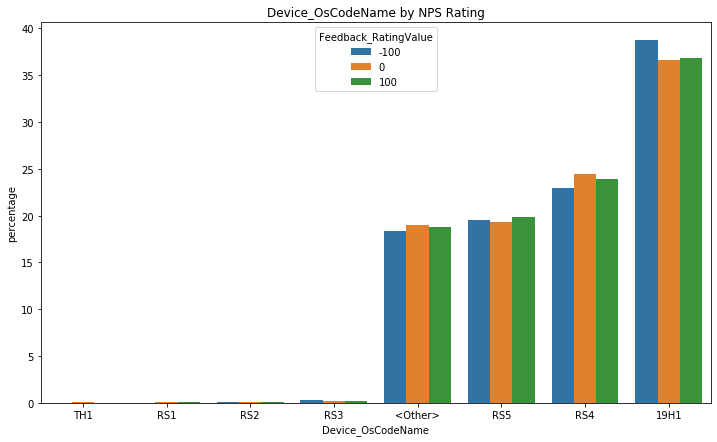

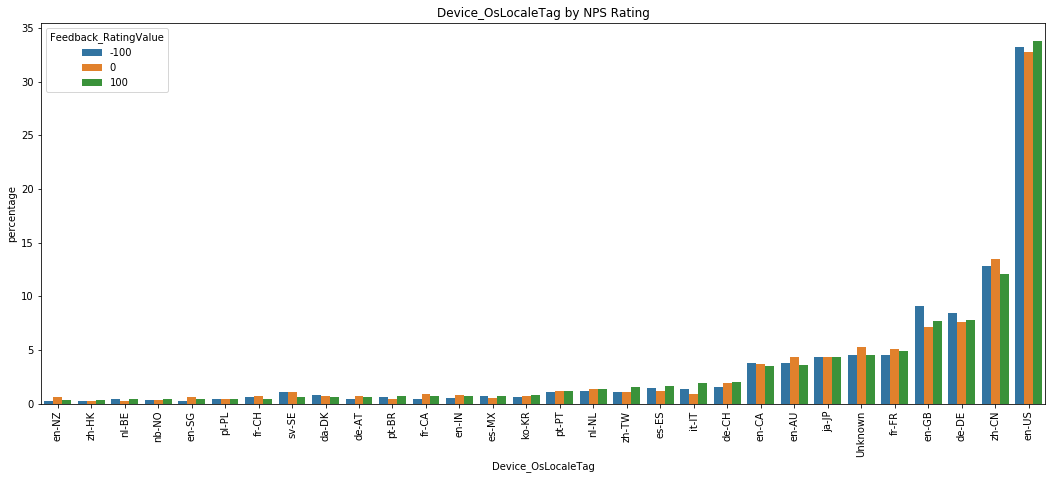

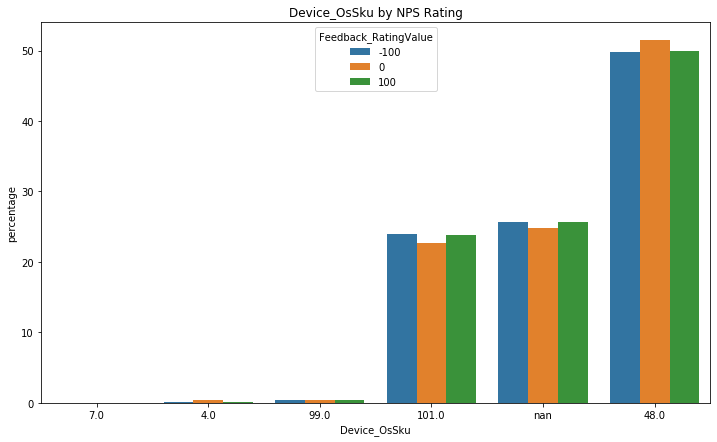

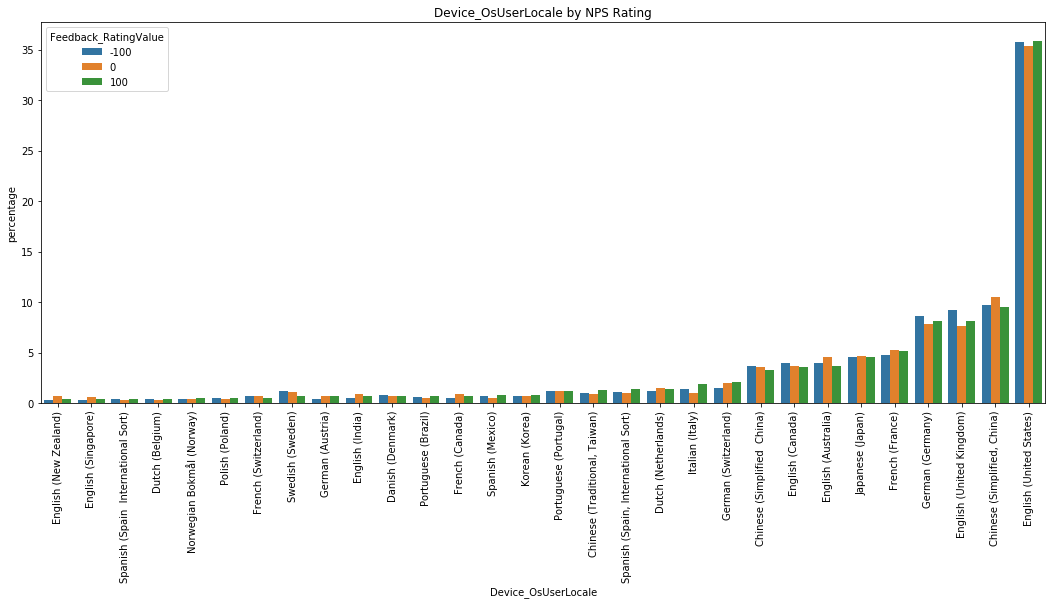

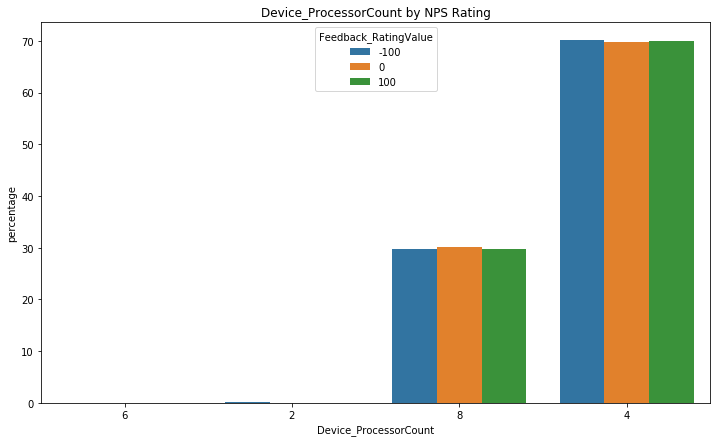

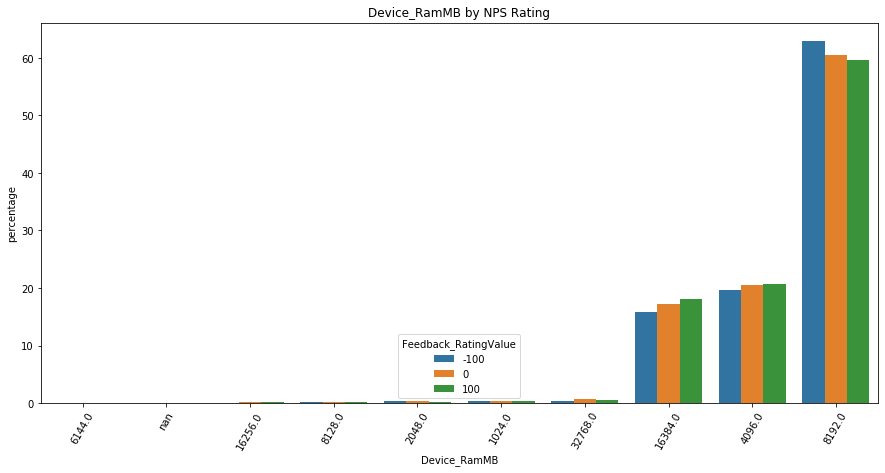

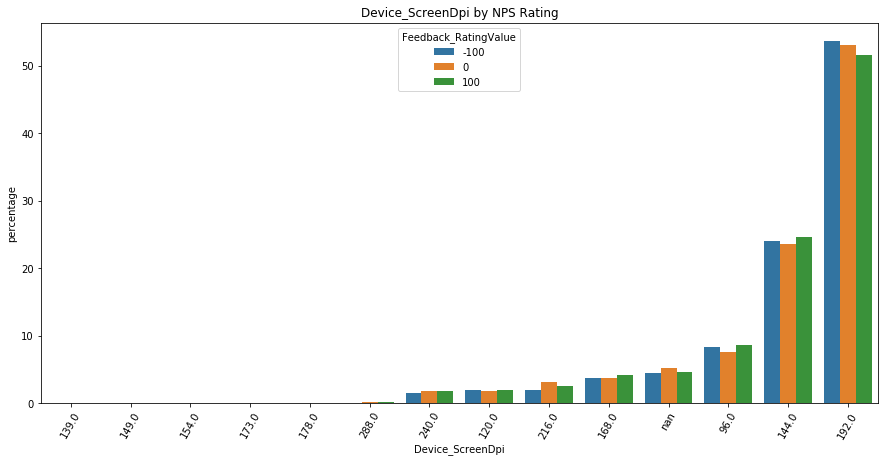

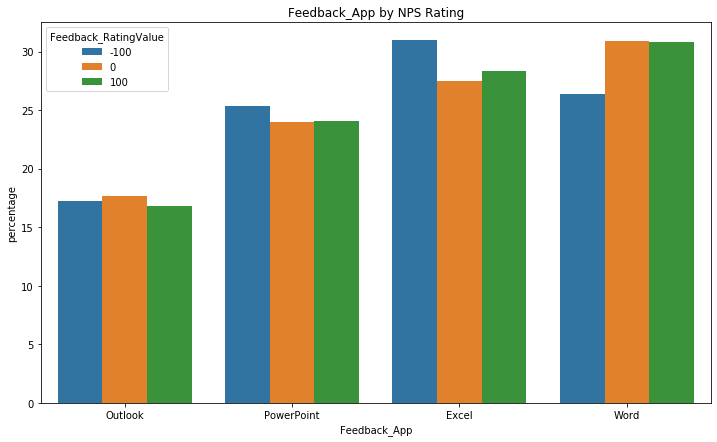

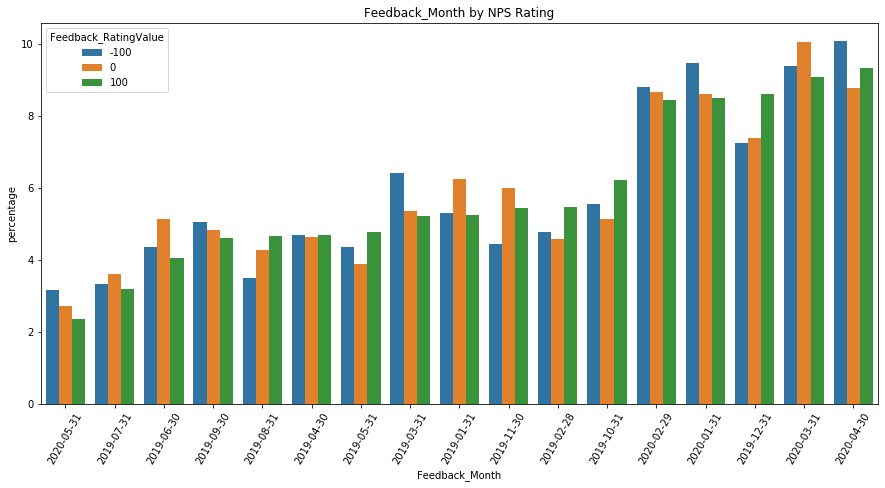

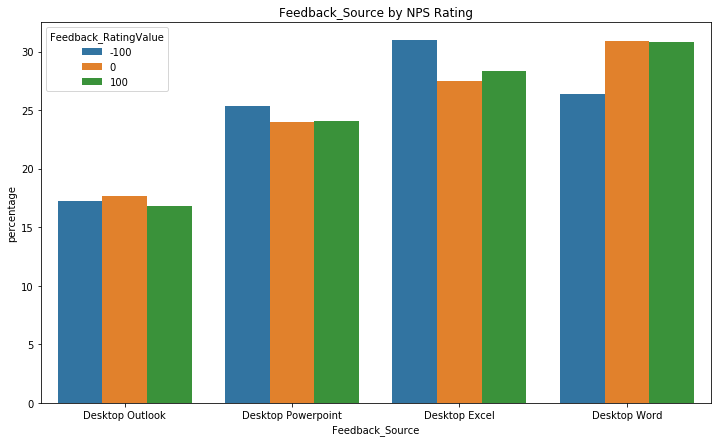

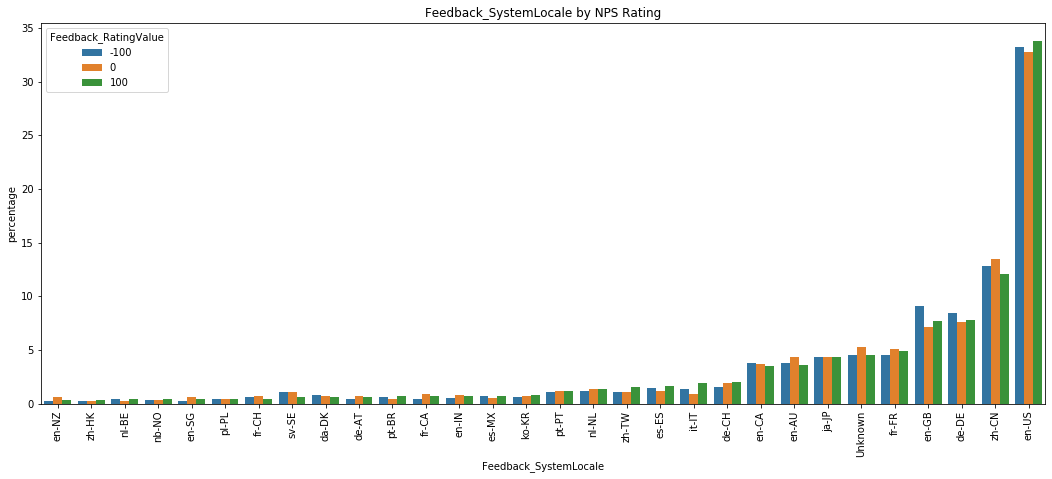

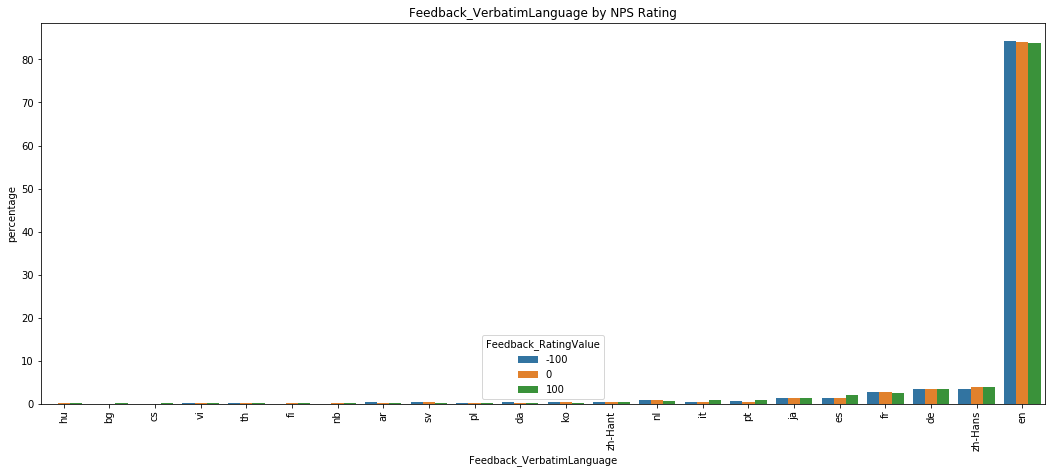

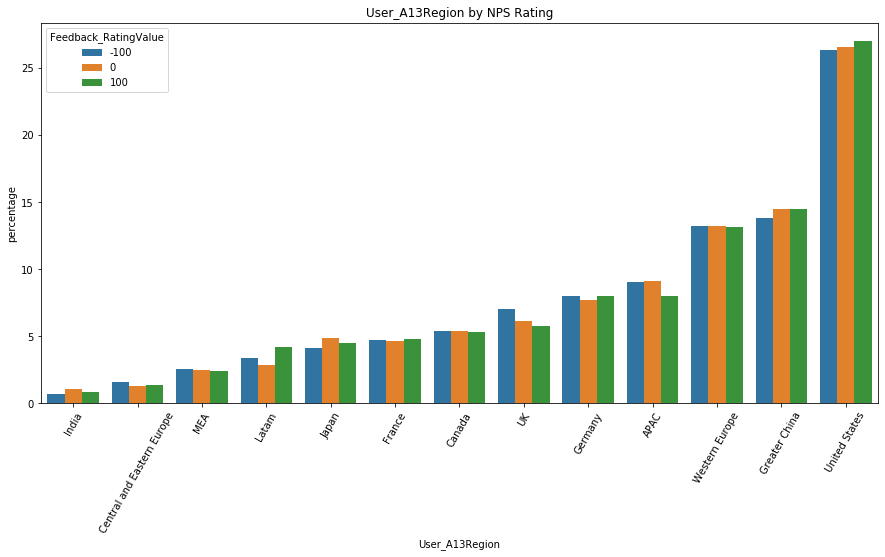

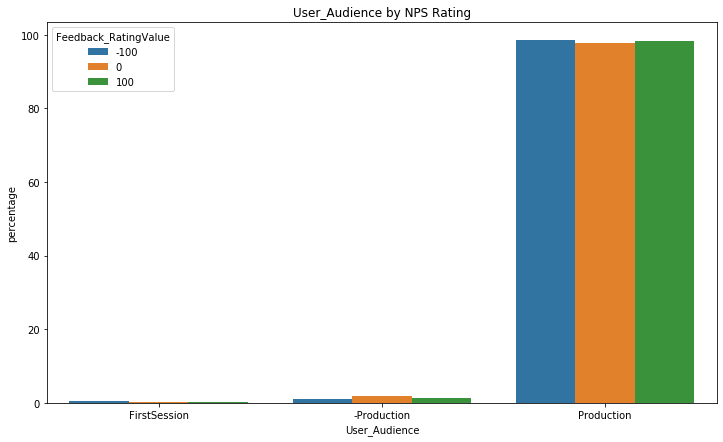

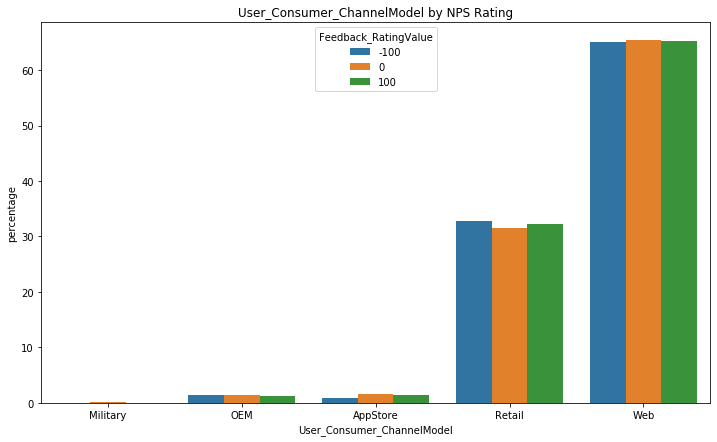

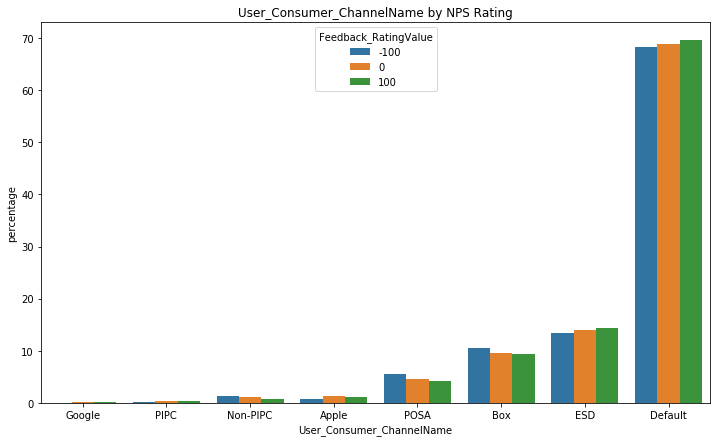

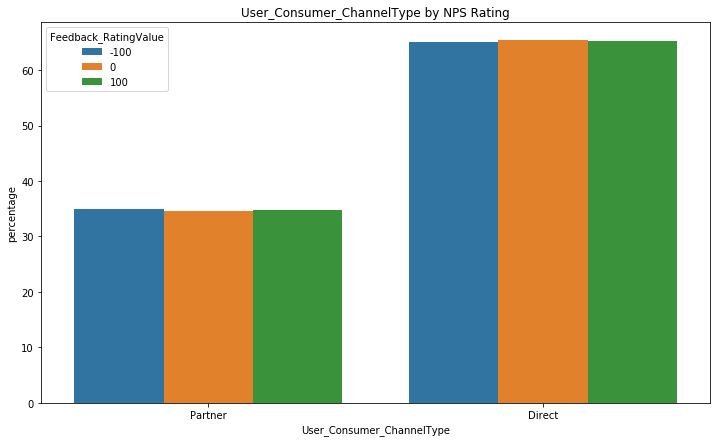

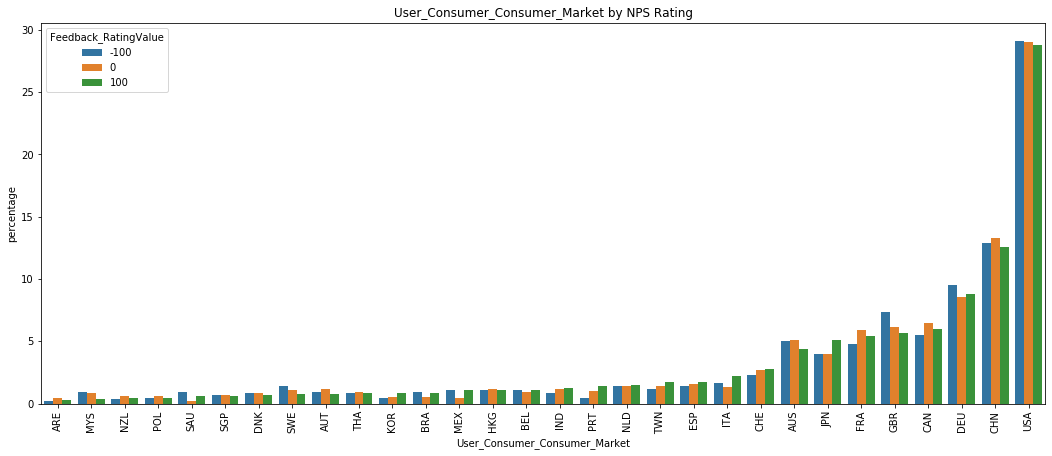

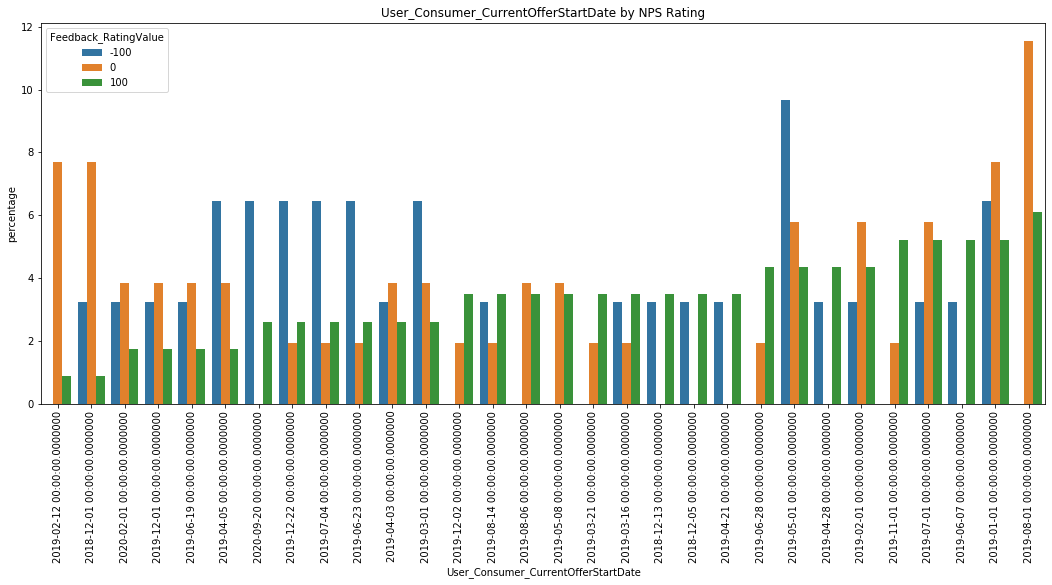

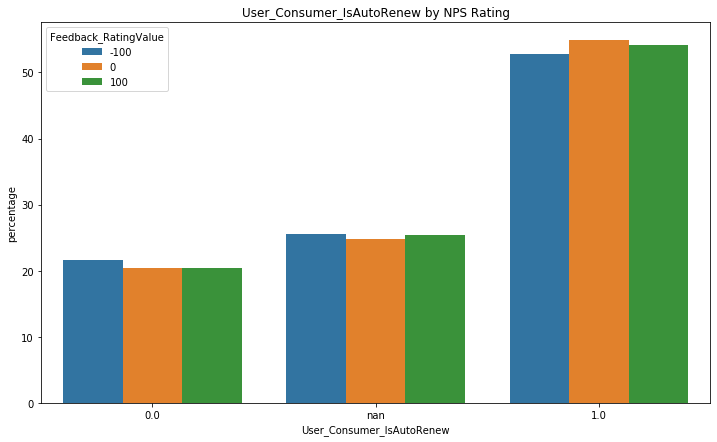

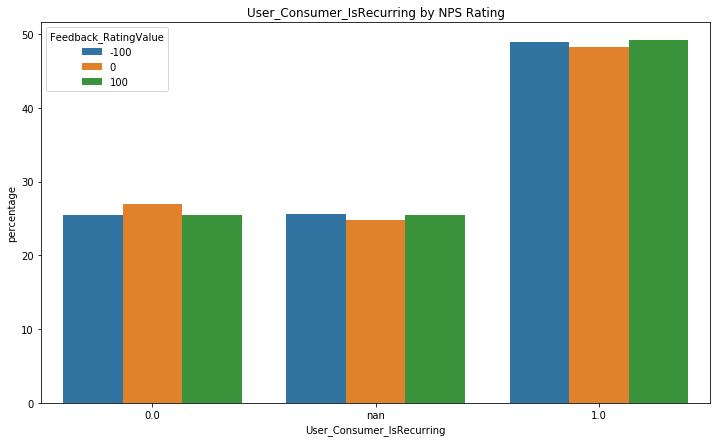

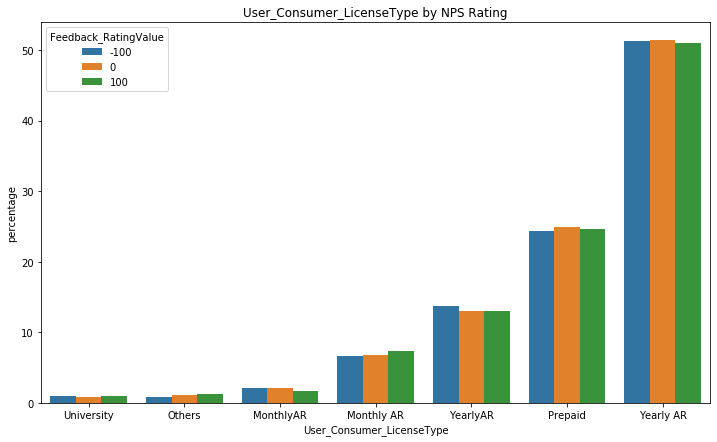

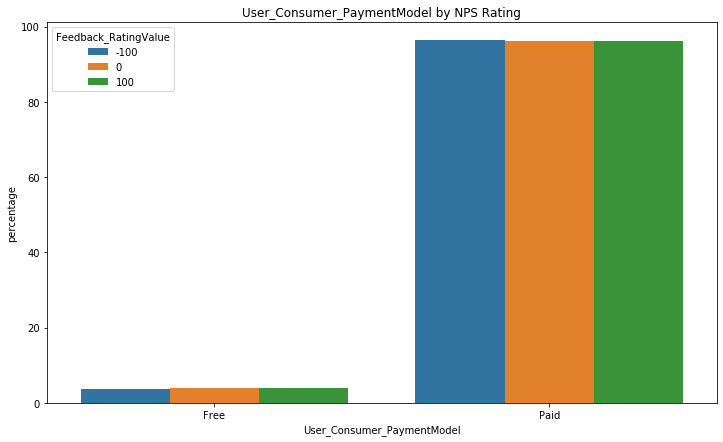

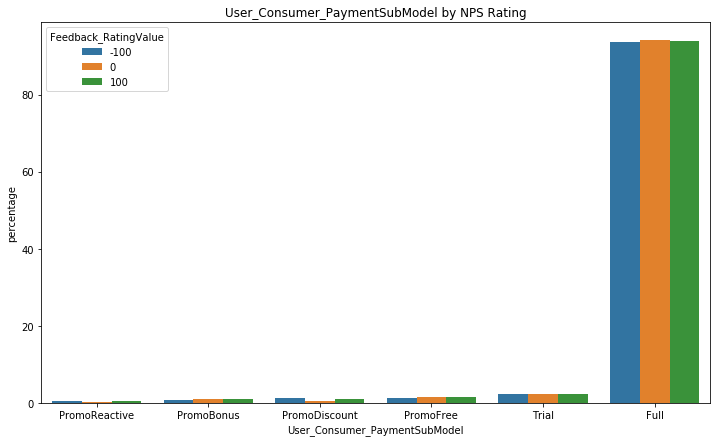

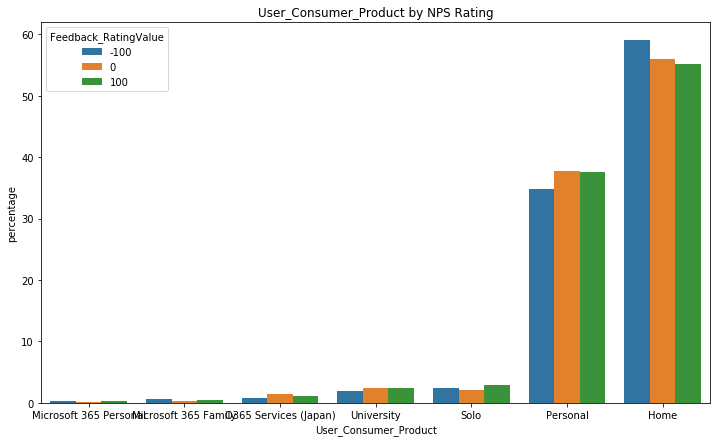

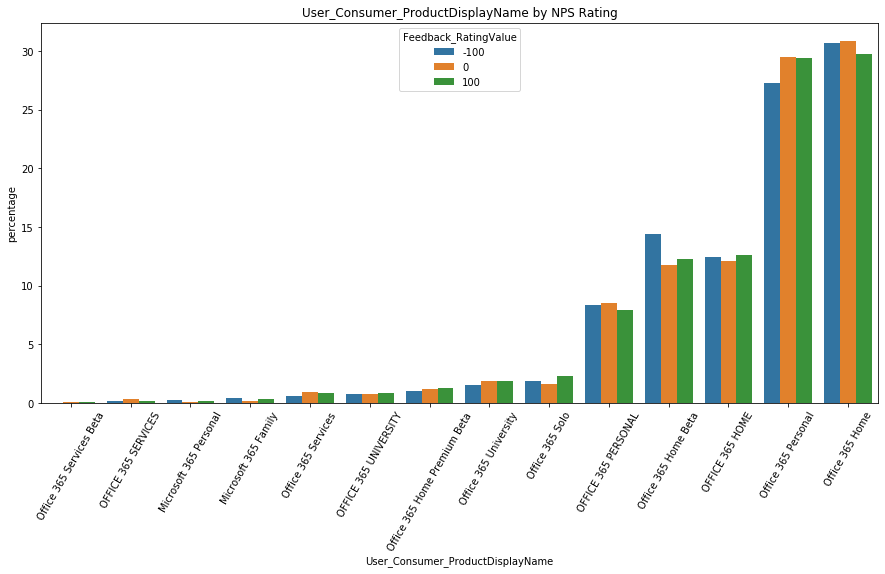

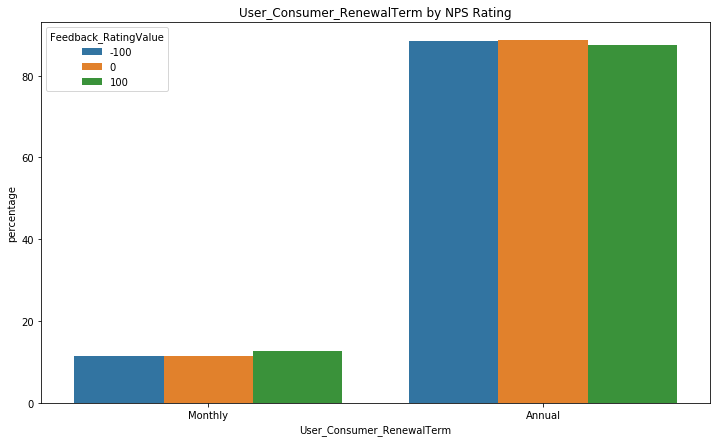

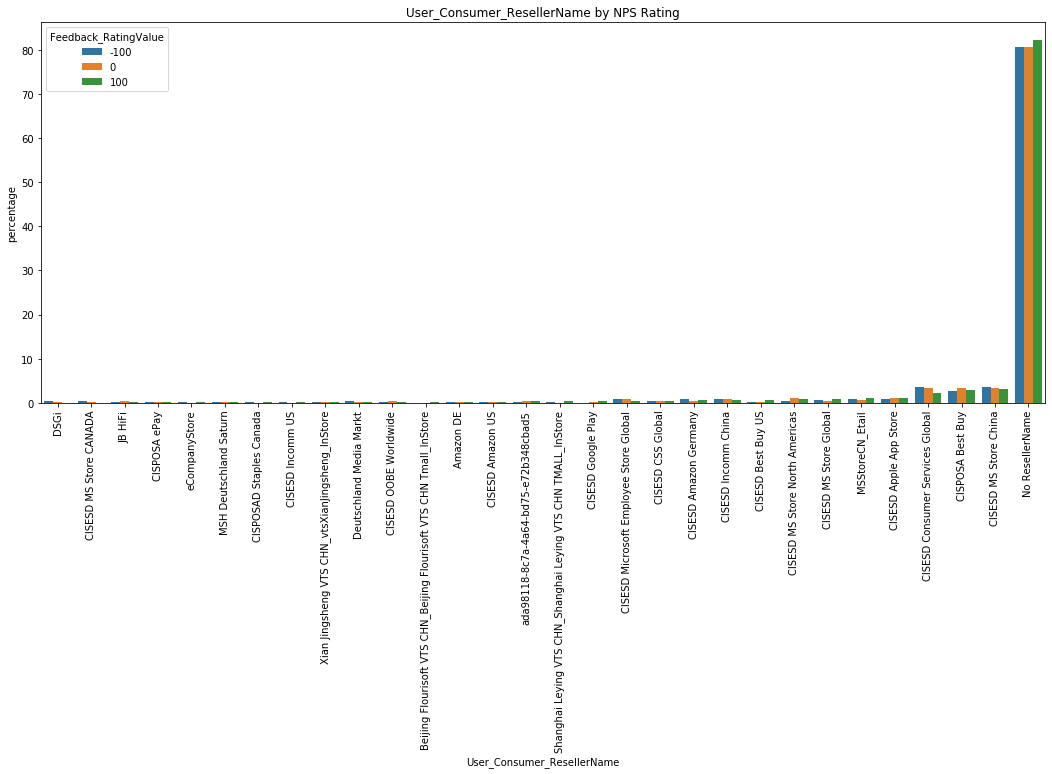

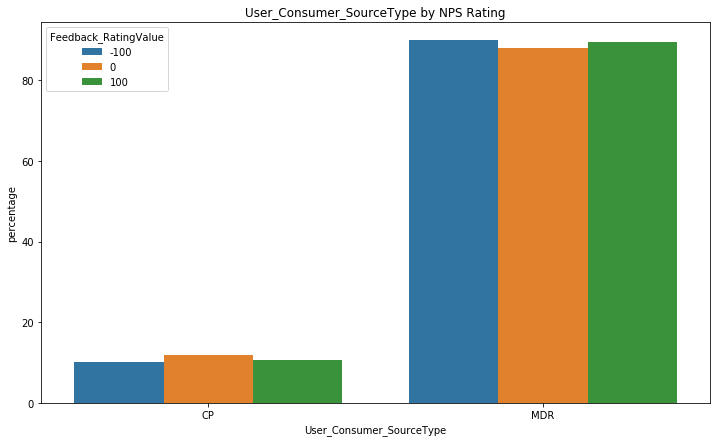

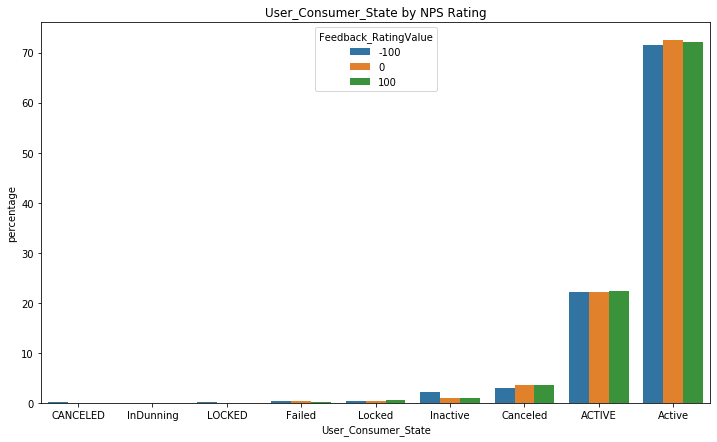

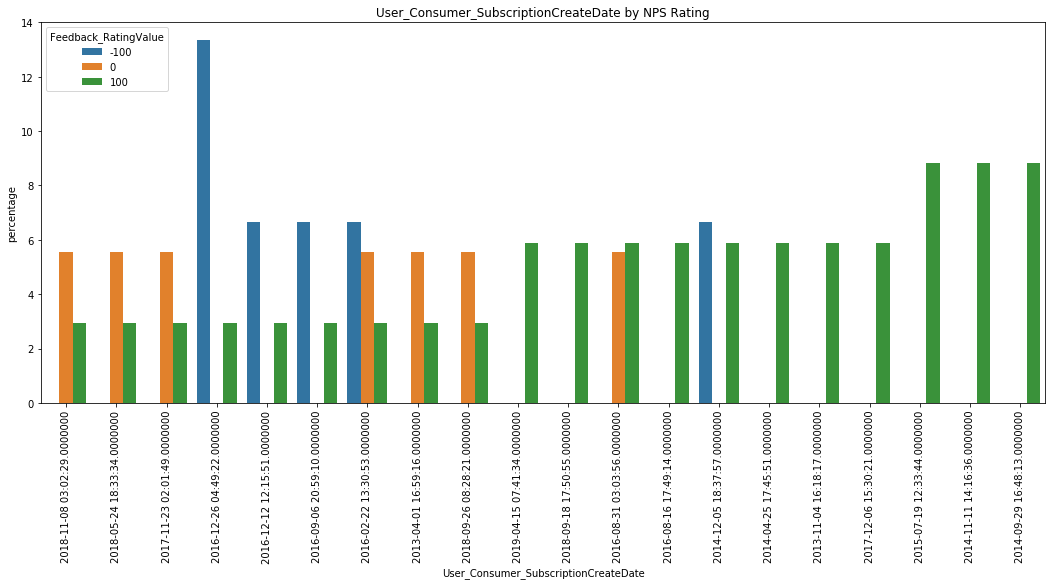

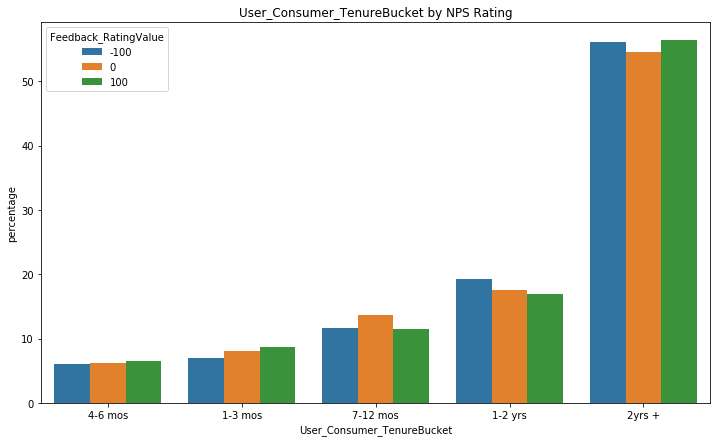

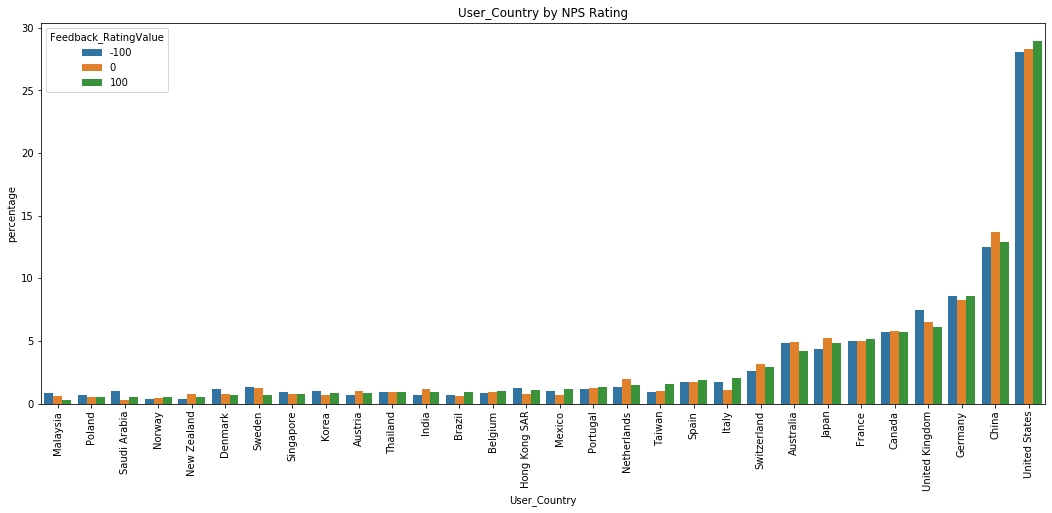

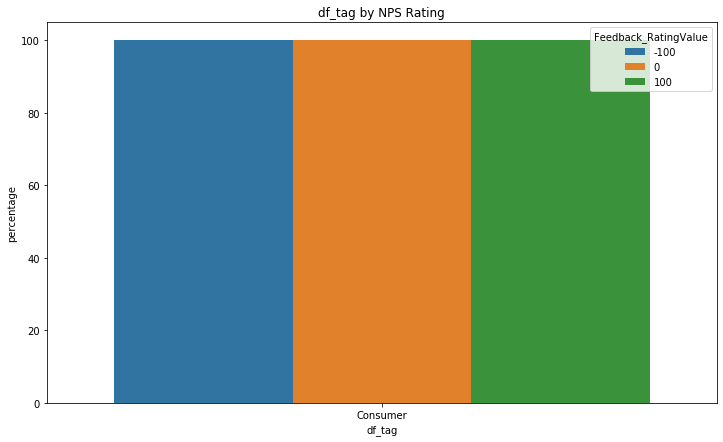

ValueError: cannot insert Feedback_RatingValue, already exists

In [230]:
plot_cats(consumer)

C:\Users\paperspace\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


(18, 3)


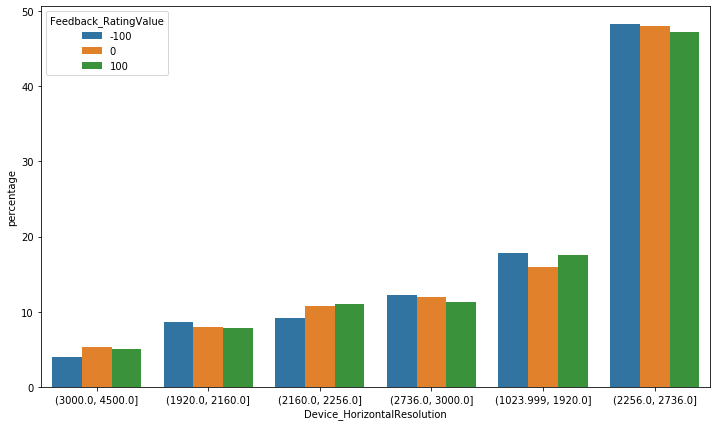

(24, 3)


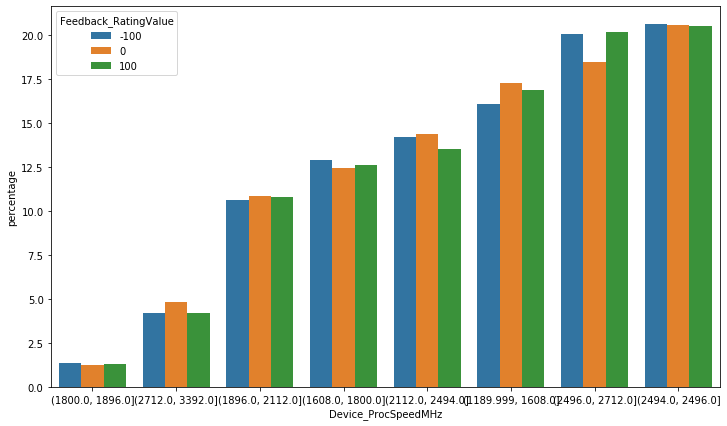

(30, 3)


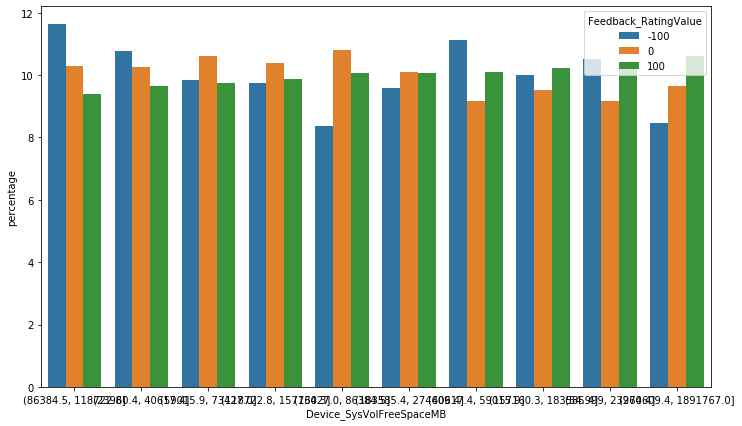

(30, 3)


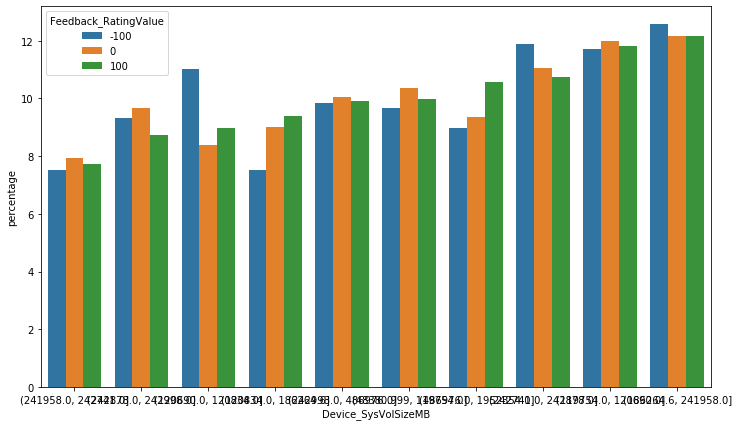

(18, 3)


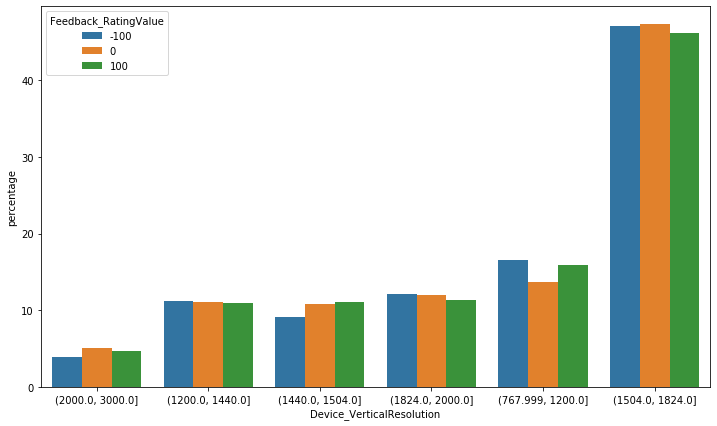

(30, 3)


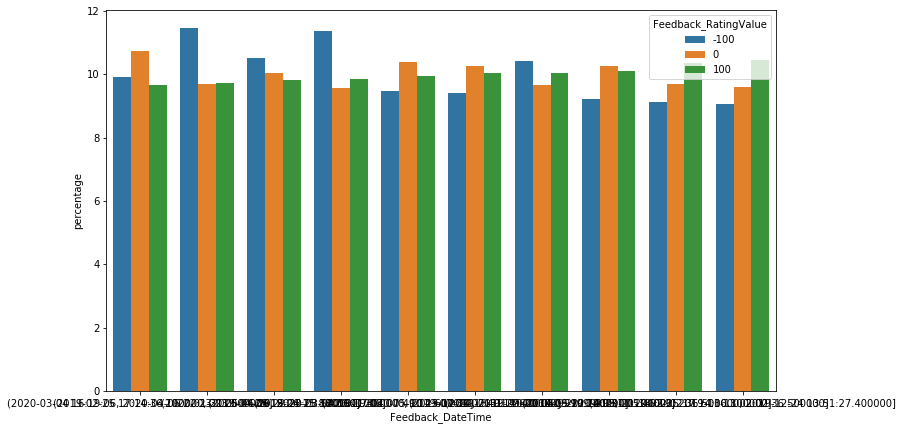

(30, 3)


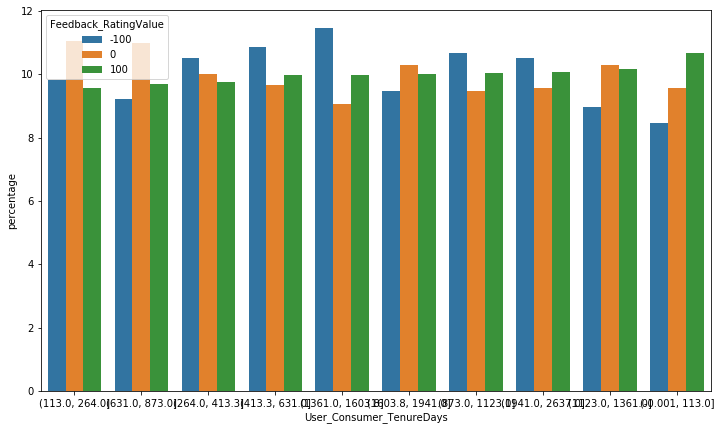

In [229]:
plot_nums(consumer, 10)

In [231]:
consumer.dtypes.value_counts()

object            44
float64           4 
int64             3 
datetime64[ns]    1 
dtype: int64